<a href="https://colab.research.google.com/github/sagiodev/stablediffusion_webui/blob/master/DreamBooth_Stable_Diffusion_SDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-click execution of Dreambooth Stable Diffusion
- Jan 16, 2023 - Fixed dreambooth model not trained properly.
- Jan 12, 2023 - Fix pytorch version error
- Jan  6, 2023 - Fix accelerate
- Jan  3, 2023 - Add instruction to find model names.
- Dec  8, 2022 - Add new xformers wheel. Add option to compile from source
- Dec  7, 2022 - Complile xformers wheel temporarily until it is available
- Dec  5, 2022 - initial version

Tutorials and prompts at [stable-diffusion-art.com](https://stable-diffusion-art.com)

The latest copy can be found [here](https://colab.research.google.com/github/sagiodev/stablediffusion_webui/blob/master/DreamBooth_Stable_Diffusion_SDA.ipynb).

Modified from [Shivam Shrirao](https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth)'s repo.

Instructions - See [acommpanying article](https://stable-diffusion-art.com/dreambooth/) for step-by-step walkthrough. Leave comment under article if you have any questions.
1. Make sure your Google Drive has more than 2GB if `fp16` is checked (recommended) or 4GB if not. 
2. Prepare you custom image to be 512x512 pixels.
1. Run the first cell by clicking the play button.
2. Grant access to Google Drive.
3. Click "Choose files" to upload your images
4. After it is complete (800 steps should take 30 mins), go to your [Google Drive](https://drive.google.com/drive/my-drive) to download your model in folder Dreambooth_model
5. Use the 2nd cell to generate new images using the new model.



Mounted at /content/drive
A100-SXM4-40GB, 40536 MiB, 40536 MiB
[*] Weights will be saved at /content/stable_diffusion_weights/output
Uploading instance images for `photo of zwx toy`


Saving 6410DB7A-4305-4B8C-8643-F2B60DC21610_1_105_c.jpeg to 6410DB7A-4305-4B8C-8643-F2B60DC21610_1_105_c.jpeg
Saving 7BFAC61C-85ED-4E82-8B8D-F518F9C54BA8_1_105_c.jpeg to 7BFAC61C-85ED-4E82-8B8D-F518F9C54BA8_1_105_c.jpeg
Saving B9C73770-329E-4D12-8FBF-648750F41D01_1_105_c.jpeg to B9C73770-329E-4D12-8FBF-648750F41D01_1_105_c.jpeg
Saving F68F3AD8-B260-4392-89E7-F9E41523C29F_1_105_c.jpeg to F68F3AD8-B260-4392-89E7-F9E41523C29F_1_105_c.jpeg
Saving FA8C3D54-A2BD-45DD-8742-97D88A2C2707_1_105_c.jpeg to FA8C3D54-A2BD-45DD-8742-97D88A2C2707_1_105_c.jpeg
Saving 3E0FD8C0-2A5B-4F60-AB75-46E7E4A54A39_1_105_c.jpeg to 3E0FD8C0-2A5B-4F60-AB75-46E7E4A54A39_1_105_c.jpeg
Saving 8A911A8C-729E-44CD-A8CD-6B8A63D4FB7E_1_105_c.jpeg to 8A911A8C-729E-44CD-A8CD-6B8A63D4FB7E_1_105_c.jpeg
Saving 667FCDEA-E101-4DFD-9151-3D555F3073D6_1_105_c.jpeg to 667FCDEA-E101-4DFD-9151-3D555F3073D6_1_105_c.jpeg
Saving 0E5AFC83-B759-4FE9-8E16-A60774E1DEDF_1_105_c.jpeg to 0E5AFC83-B759-4FE9-8E16-A60774E1DEDF_1_105_c.jpeg
Saving 21A

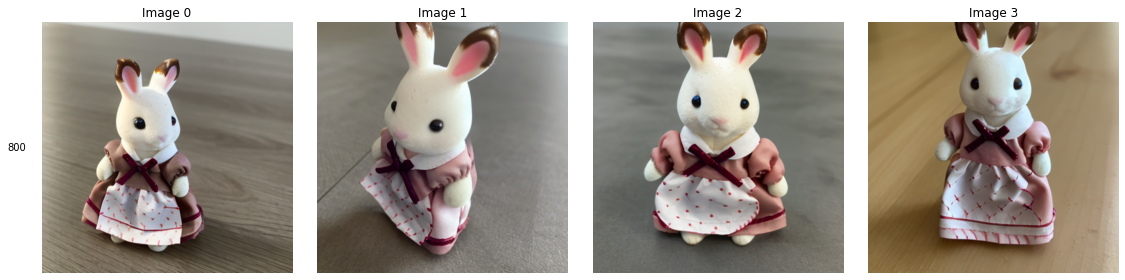

In [1]:
import time
time_start = time.time()
#@title DreamBooth
HUGGINGFACE_TOKEN = "" 

#@markdown Name/Path of the initial model. (Find model name [here](https://huggingface.co/models))
MODEL_NAME = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}

#@markdown Enter instance prompt and class prompt.\
#@markdown Example 1: photo of zwx person, photo of a person\
#@markdown Example 2: photo of zwx toy, photo of a toy
instance_prompt = "photo of zwx toy" #@param {type:"string"}
class_prompt =  "photo of a toy" #@param {type:"string"}

training_steps = 800 #@param {type:"integer"}

#@markdown  Convert to fp16? (takes half the space (2GB)).
fp16 = True #@param {type: "boolean"}
#@markdown  Compile xformers (Try only if you see xformers error. Will take 1 more hour).
complie_xformers = False #@param {type: "boolean"}

save_to_gdrive = True
from google.colab import drive
if save_to_gdrive:
  drive.mount('/content/drive')


#@markdown Clear log after run?
CLEAR_LOG = True #@param {type:"boolean"}


OUTPUT_DIR = "stable_diffusion_weights/output" 
OUTPUT_DIR = "/content/" + OUTPUT_DIR

# Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR


# You can also add multiple concepts here. Try tweaking `--max_train_steps` accordingly.

concepts_list = [
    {
        "instance_prompt":      instance_prompt,
        "class_prompt":         class_prompt,
        "instance_data_dir":    "/content/data/instance",
        "class_data_dir":       "/content/data/class"
    },
#     {
#         "instance_prompt":      "photo of ukj person",
#         "class_prompt":         "photo of a person",
#         "instance_data_dir":    "/content/data/ukj",
#         "class_data_dir":       "/content/data/person"
#     }
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)


import os
from google.colab import files
import shutil

for c in concepts_list:
    print(f"Uploading instance images for `{c['instance_prompt']}`")
    uploaded = files.upload()
    for filename in uploaded.keys():
        dst_path = os.path.join(c['instance_data_dir'], filename)
        shutil.move(filename, dst_path)


def clear():
    from IPython.display import clear_output; return clear_output()



# huggingface token
!mkdir -p ~/.huggingface
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token


# install repos
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort

# install xformer wheel
print('Install xformers')
if complie_xformers:
  %pip install git+https://github.com/facebookresearch/xformers@4c06c79#egg=xformers
else:
  %pip install  --no-deps -q https://github.com/brian6091/xformers-wheels/releases/download/0.0.15.dev0%2B4c06c79/xformers-0.0.15.dev0+4c06c79.d20221205-cp38-cp38-linux_x86_64.whl
#%pip install -q https://github.com/metrolobo/xformers_wheels/releases/download/4c06c79_various6/xformers-0.0.15.dev0_4c06c79.d20221201-cp38-cp38-linux_x86_64.whl
#%pip install -q https://github.com/ShivamShrirao/xformers-wheels/releases/download/4c06c79/xformers-0.0.15.dev0+4c06c79.d20221201-cp38-cp38-linux_x86_64.whl


############## Edit this section to customize parameters
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision="fp16" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=$training_steps \
  --save_interval=10000 \
  --save_sample_prompt="$instance_prompt" \
  --concepts_list="concepts_list.json"

########################################

# Reduce the `--save_interval` to lower than `--max_train_steps` to save weights from intermediate steps.
# `--save_sample_prompt` can be same as `--instance_prompt` to generate intermediate samples (saved along with weights in samples directory).

WEIGHTS_DIR = ""
if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]


ckpt_path = WEIGHTS_DIR + "/model.ckpt"

half_arg = ""
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")


if CLEAR_LOG:
  clear()

print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")
minutes = (time.time()-time_start)/60
print("Dreambooth completed successfully. It took %1.1f minutes."%minutes)
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')
        
plt.tight_layout()
plt.savefig('grid.png', dpi=72)

if save_to_gdrive:
  import os.path
  gPath = "/content/drive/MyDrive/Dreambooth_model"
  !mkdir -p $gPath
  filename = 'model.ckpt'
  i = 1
  ckpt_gpath = gPath + '/' + filename
  while os.path.isfile(ckpt_gpath):
    filename = 'model%d.ckpt'%i
    ckpt_gpath = gPath + '/' + filename
    i += 1
  ckpt_gpath = gPath + '/' + filename
  !cp $ckpt_path $ckpt_gpath
  print('Model saved to %s'%ckpt_gpath)


/usr/local/lib/python3.8/dist-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.9.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json` file
  warnings.warn(warning + message, FutureWarning)


  0%|          | 0/30 [00:00<?, ?it/s]

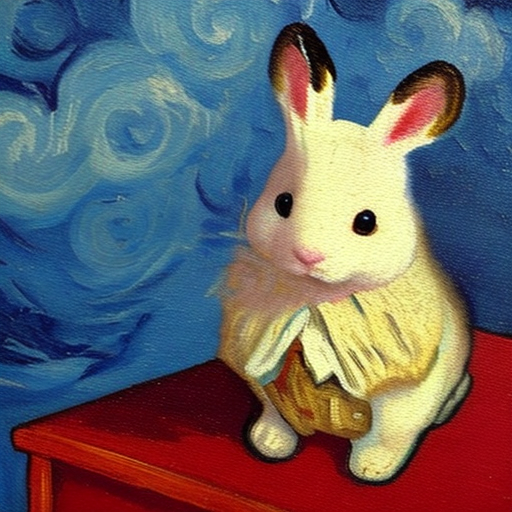

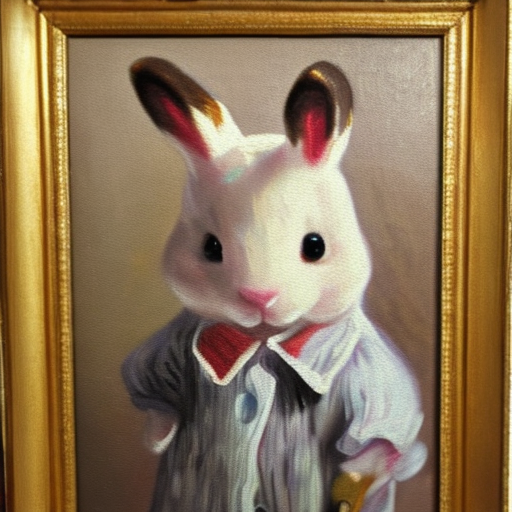

In [2]:
#@title Test image generation from model

prompt = "oil painting of zwx in style of van gogh" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
num_samples = 2 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 30 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}
seed = -1 #@param {type:"number"}


import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive
if 'pipe' not in locals():
  scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
  pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  g_cuda = None



g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)


with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

In [ ]:
#@markdown Run Gradio UI for generating images.
import gradio as gr

def inference(prompt, negative_prompt, num_samples, height=512, width=512, num_inference_steps=50, guidance_scale=7.5):
    with torch.autocast("cuda"), torch.inference_mode():
        return pipe(
                prompt, height=int(height), width=int(width),
                negative_prompt=negative_prompt,
                num_images_per_prompt=int(num_samples),
                num_inference_steps=int(num_inference_steps), guidance_scale=guidance_scale,
                generator=g_cuda
            ).images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="Prompt", value="photo of zwx dog in a bucket")
            negative_prompt = gr.Textbox(label="Negative Prompt", value="")
            run = gr.Button(value="Generate")
            with gr.Row():
                num_samples = gr.Number(label="Number of Samples", value=4)
                guidance_scale = gr.Number(label="Guidance Scale", value=7.5)
            with gr.Row():
                height = gr.Number(label="Height", value=512)
                width = gr.Number(label="Width", value=512)
            num_inference_steps = gr.Slider(label="Steps", value=50)
        with gr.Column():
            gallery = gr.Gallery()

    run.click(inference, inputs=[prompt, negative_prompt, num_samples, height, width, num_inference_steps, guidance_scale], outputs=gallery)

demo.launch(debug=True)

In [ ]:
#@title (Optional) Delete diffuser and old weights and only keep the ckpt to free up drive space.

#@markdown [ ! ] Caution, Only execute if you are sure u want to delete the diffuser format weights and only use the ckpt.
import shutil
from glob import glob
import os
for f in glob(OUTPUT_DIR+os.sep+"*"):
    if f != WEIGHTS_DIR:
        shutil.rmtree(f)
        print("Deleted", f)
for f in glob(WEIGHTS_DIR+"/*"):
    if not f.endswith(".ckpt") or not f.endswith(".json"):
        try:
            shutil.rmtree(f)
        except NotADirectoryError:
            continue
        print("Deleted", f)

# Start Training

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |
